In [33]:
pip install skforecast

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

# Override the default linewidth and markersize
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# ----------------------------------------------------------
# Stats and Prediction
import statistics as stats
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----------------------------------------------------------
# Others
import datetime as dt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [35]:
# Load and preprocess data from CSV file
def load_and_process_data():
    # Read the CSV file into a DataFrame
    data_frame = pd.read_csv('/content/merged_df.csv')
    # Set 'DATETIME' as the index and convert it to DateTime type
    data_frame.set_index('DATETIME', inplace=True)
    data_frame.index = pd.to_datetime(data_frame.index)
    return data_frame


In [36]:
# Split the data into training and testing sets based on date
def split_data(df):
    # Filter rows based on the DateTime index
    training_data = df[df.index < pd.Timestamp('2021-03-01')]
    testing_data = df[df.index >= pd.Timestamp('2021-03-01')]
    return training_data, testing_data

In [37]:
# Plot the training and testing data sets
def plot_data(train_set, test_set):
    fig, ax = plt.subplots(figsize=(15, 5))
    # Plot data and set labels
    train_set['TOTALDEMAND'].plot(ax=ax, color='green')
    test_set['TOTALDEMAND'].plot(ax=ax, color='orange')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.legend(['Training Data', 'Test Data'])
    plt.show()

In [38]:
# Create new features based on the DateTime index
def create_features(df):
    # Extract various time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [39]:
# Add lag features to the DataFrame
def add_lag_features(df):
    # Loop through different time intervals and create lag features
    for i in range(1, 6):
        days = i * 364
        df[f'lag_{i}'] = (df.index - pd.Timedelta(f'{days} days')).map(df['TOTALDEMAND'].to_dict())
    return df


In [40]:
# Train the model and return predictions and RMSE score
def run_model(train_x, train_y, test_x, test_y):
    # Initialize XGBoost Regressor
    model = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:linear',
        max_depth=3,
        learning_rate=0.01
    )
    # Train the model
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=100)
    # Make predictions
    predictions = model.predict(test_x)
    # Calculate RMSE
    return predictions, np.sqrt(mean_squared_error(test_y, predictions))

In [41]:
def add_lags(df):
    target_map = df['TOTALDEMAND'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('1456 days')).map(target_map)
    df['lag5'] = (df.index - pd.Timedelta('1820 days')).map(target_map)
    return df

In [42]:
def plot_time_series_split(df, n_splits=5):
    tss = TimeSeriesSplit(n_splits=n_splits, test_size=24*365, gap=24)
    fig, axs = plt.subplots(n_splits, 1, figsize=(15, 15), sharex=True)

    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train['TOTALDEMAND'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}', color='green')
        test['TOTALDEMAND'].plot(ax=axs[fold], label='Test Set', color='orange')
        axs[fold].axvline(test.index.min(), color='black', ls='--')
        fold += 1
    plt.show()



In [43]:
def retrain_and_forecast(df):
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5']
    TARGET = 'TOTALDEMAND'

    X_all = df[FEATURES]
    y_all = df[TARGET]

    #reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=500, objective='reg:linear', max_depth=3, learning_rate=0.01)
    reg = xgb.XGBRegressor(objective='reg:squarederror', base_score=0.5, booster='gbtree', n_estimators=500, max_depth=3, learning_rate=0.01)

    reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

    future = pd.date_range('2022-08-02','2027-08-01', freq='1h')
    future_df = pd.DataFrame(index=future)
    future_df['isFuture'] = True
    df['isFuture'] = False
    df_and_future = pd.concat([df, future_df])
    df_and_future = create_features(df_and_future)
    df_and_future = add_lags(df_and_future)

    future_w_features = df_and_future.query('isFuture').copy()
    future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
    future_w_features['pred'].plot(figsize=(17, 6), color='green', ms=1, lw=1, title='Future Forecast 5 Years')
    plt.show()

In [44]:

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 8))  # Added this line to set figure size
    plt.hist(residuals, bins=30, color='green', alpha=0.7)
    plt.title('Residual Histogram')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()


In [45]:

def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(12, 8))  # Added this line to set figure size
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='green', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()



In [46]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")

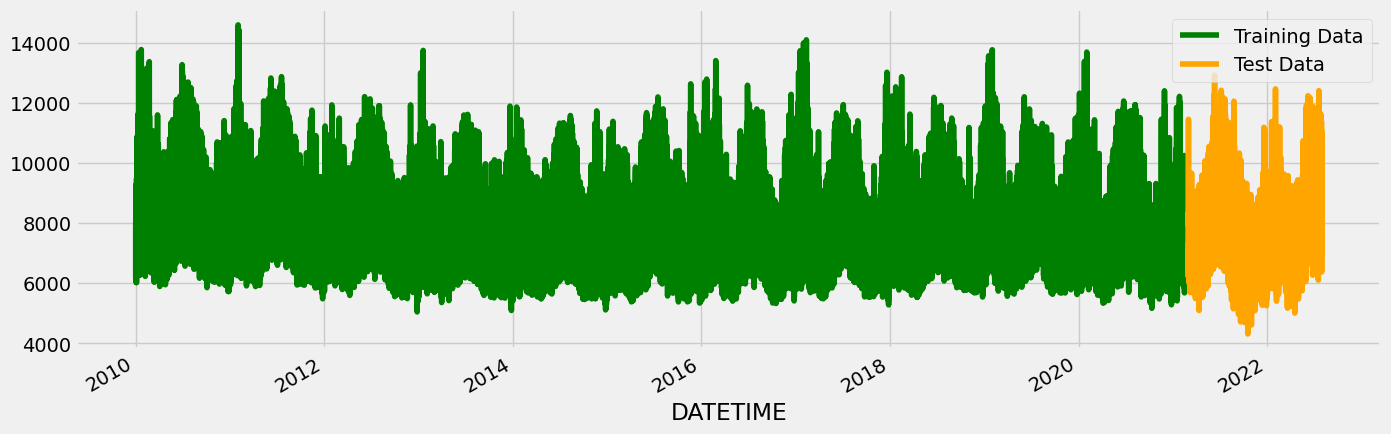

[04:57:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8175.70338	validation_1-rmse:7850.45551
[100]	validation_0-rmse:3066.72740	validation_1-rmse:2834.07764
[200]	validation_0-rmse:1284.04650	validation_1-rmse:1130.07764
[300]	validation_0-rmse:755.77200	validation_1-rmse:733.88936
[400]	validation_0-rmse:634.70803	validation_1-rmse:699.62538
[432]	validation_0-rmse:620.49647	validation_1-rmse:702.19357
[04:59:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8160.80245	validation_1-rmse:7549.89388
[100]	validation_0-rmse:3062.13847	validation_1-rmse:2737.94898
[200]	validation_0-rmse:1284.64010	validation_1-rmse:1139.27330
[300]	validation_0-rmse:759.69147	validation_1-rmse:780.95182
[400]	validation_0-rmse:642.50562	validation_1-rmse:749.57488
[487]	validation_0-rmse:614.35819	validation_1-rmse:748.10864
[05:01:18]

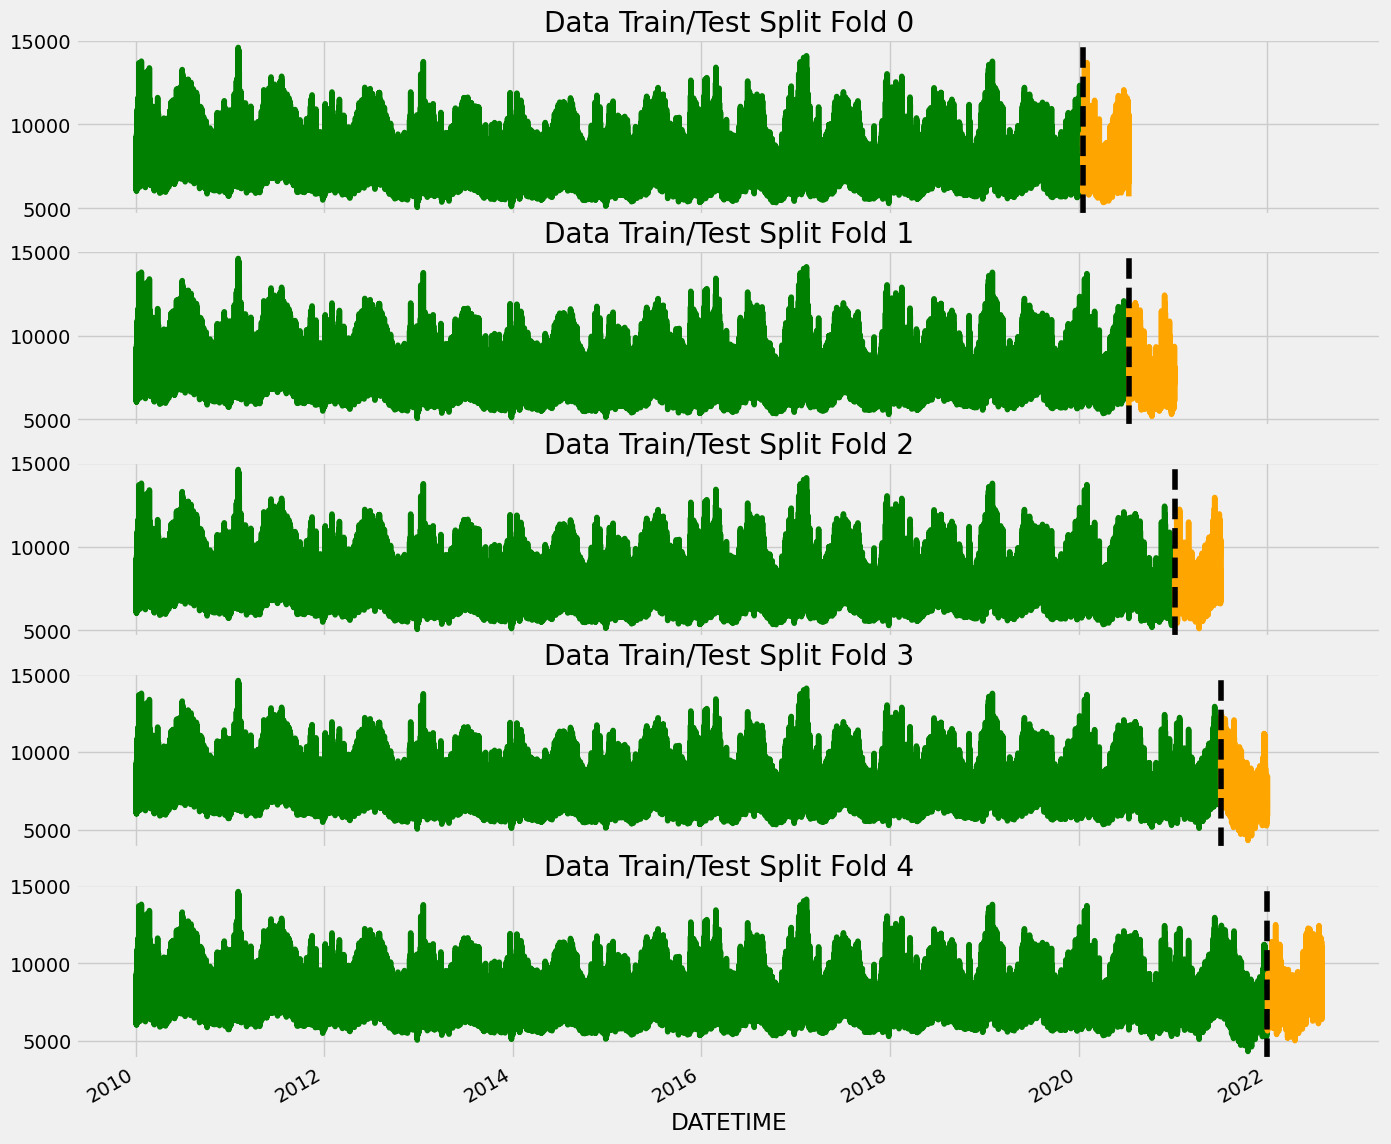

[0]	validation_0-rmse:8083.57740
[100]	validation_0-rmse:3037.53814
[200]	validation_0-rmse:1284.72369
[300]	validation_0-rmse:771.45618
[400]	validation_0-rmse:654.70188
[499]	validation_0-rmse:626.19289
Mean Absolute Error: 430.58
Root Mean Squared Error: 626.19
R-squared: 0.77


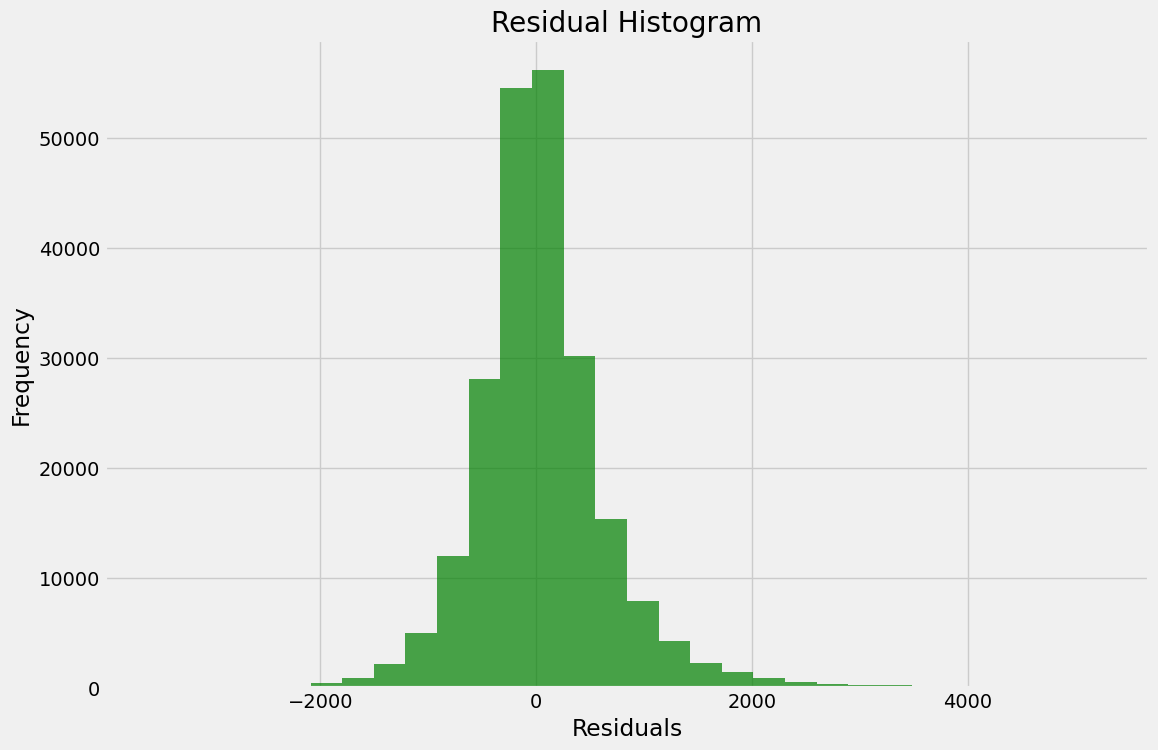

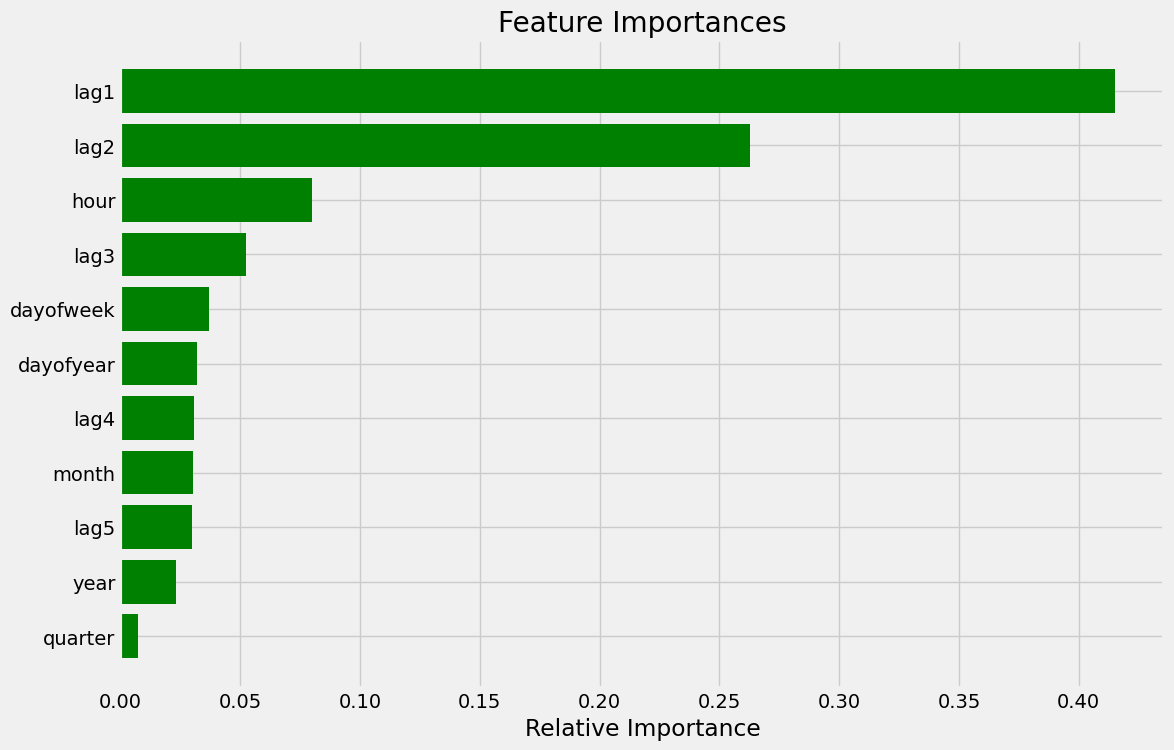

[0]	validation_0-rmse:8083.57740
[100]	validation_0-rmse:3037.53814
[200]	validation_0-rmse:1284.72369
[300]	validation_0-rmse:771.45618
[400]	validation_0-rmse:654.70188
[499]	validation_0-rmse:626.19289


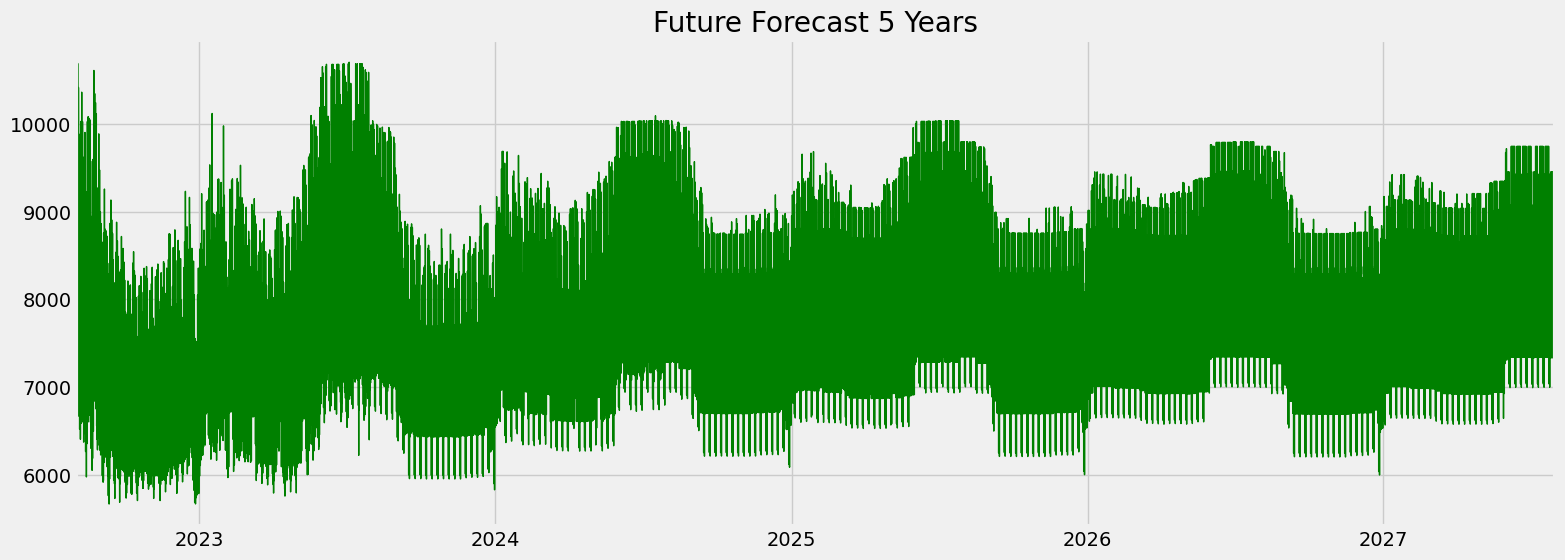

In [47]:
# Main Execution
if __name__ == "__main__":
    # Load and preprocess the data
    df = load_and_process_data()

    # Call the add_lags function
    df = add_lags(df)

    # Split the data into training and testing sets
    train_set, test_set = split_data(df)
    # Plot the data
    plot_data(train_set, test_set)

    # Initialize TimeSeriesSplit
    time_splitter = TimeSeriesSplit(n_splits=5, test_size=24*365, gap=24)
    df = df.sort_index()

    fold_count = 0
    pred_list = []
    score_list = []

    # Perform TimeSeriesSplit and model training
    for train_indices, test_indices in time_splitter.split(df):
        train_data = df.iloc[train_indices]
        test_data = df.iloc[test_indices]

        train_data = create_time_features(train_data)
        test_data = create_time_features(test_data)

        # Define features and target variable
        features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5']
        target = 'TOTALDEMAND'

        train_x = train_data[features]
        train_y = train_data[target]

        test_x = test_data[features]
        test_y = test_data[target]

        # Train the model and get predictions
        pred, score = run_model(train_x, train_y, test_x, test_y)
        pred_list.append(pred)
        score_list.append(score)
        fold_count += 1

    print(f'Average Score Across Folds: {np.mean(score_list):.4f}')
    print(f'Individual Fold Scores: {score_list}')

    # Plot Time Series Splits
    plot_time_series_split(df)

    # Retrain and Forecast
    df = create_features(df)
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5']
    TARGET = 'TOTALDEMAND'

    X_all = df[FEATURES]
    y_all = df[TARGET]
    reg = xgb.XGBRegressor(objective='reg:squarederror', base_score=0.5, booster='gbtree', n_estimators=500, max_depth=3, learning_rate=0.01)


    reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

    # Calculate Metrics
    y_pred = reg.predict(X_all)
    calculate_metrics(y_all, y_pred)

    # Visualizations
    plot_residuals(y_all, y_pred)
    plot_feature_importance(reg, FEATURES)

    retrain_and_forecast(df)